In [2]:
import cv2
import matplotlib.pyplot as plt
import pyflow.pyflow as pyflow
import numpy as np
from evaluation import *

%load_ext autoreload
%autoreload 2

In [3]:
# Code imported from https://github.com/mcv-m6-video/mcv-m6-2023-team2/blob/main/week4/utils_w4.py
def convert_optical_flow_to_image(flow):
    # The 3-channel uint16 PNG images that comprise optical flow maps contain information
    # on the u-component in the first channel, the v-component in the second channel,
    # and whether a valid ground truth optical flow value exists for a given pixel in the third channel.
    # A value of 1 in the third channel indicates the existence of a valid optical flow value
    # while a value of 0 indicates otherwise. To convert the u- and v-flow values from
    # their original uint16 format to floating point values, one can do so by subtracting 2^15 from the value,
    # converting it to float, and then dividing the result by 64.

    img_u = (flow[:, :, 2] - 2 ** 15) / 64
    img_v = (flow[:, :, 1] - 2 ** 15) / 64

    assert (flow[:, :, 0] > 1).sum() == 0 # all values are 0 or 1

    img_u[flow[:, :, 0] == 0] = 0
    img_v[flow[:, :, 0] == 0] = 0

    optical_flow = np.dstack((img_u, img_v, flow[:, :, 0]))
    return optical_flow

gt_flow = cv2.imread(r'kitti_data\training\flow_noc\000045_10.png', cv2.IMREAD_UNCHANGED).astype(np.double)
gt_flow_img = convert_optical_flow_to_image(gt_flow)

In [4]:
first = cv2.imread(r'kitti_data\training\image_0\000045_10.png').astype(float)  / 255
second = cv2.imread(r'kitti_data\training\image_0\000045_11.png').astype(float) / 255

min_error = 100000
for alpha in [0.005, 0.01, 0.05, 0.1]:
    for ratio in [0.25, 0.5, 0.75, 0.9]:
        for minWidth in [5, 10, 30]:
            for nOuterFPIterations in [3, 7, 11]:
                for nInnerFPIterations in [1, 5, 9]:
                    for nSORIterations in [30, 70]:
                        print(f'Params: {alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations, nSORIterations}')
                        u, v, im2W = pyflow.coarse2fine_flow(first, second, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations, nSORIterations)
                        pred_flow = np.dstack((u, v, np.ones_like(u)))
                        msen, pepn = compute_errors(gt_flow_img, pred_flow, 3, 'results_pyflow/', plots=False)
                        if msen < min_error:
                            min_error = msen
                            best_params = (alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations, nSORIterations)
                            print(f'New best params: {best_params} with error {min_error}')

Params: (0.005, 0.25, 5, 3, 1, 30)
Params: (0.005, 0.25, 5, 3, 1, 70)
Params: (0.005, 0.25, 5, 3, 5, 30)
Params: (0.005, 0.25, 5, 3, 5, 70)
Params: (0.005, 0.25, 5, 3, 9, 30)
Params: (0.005, 0.25, 5, 3, 9, 70)
Params: (0.005, 0.25, 5, 7, 1, 30)
Params: (0.005, 0.25, 5, 7, 1, 70)
Params: (0.005, 0.25, 5, 7, 5, 30)
Params: (0.005, 0.25, 5, 7, 5, 70)
Params: (0.005, 0.25, 5, 7, 9, 30)
Params: (0.005, 0.25, 5, 7, 9, 70)
Params: (0.005, 0.25, 5, 11, 1, 30)
Params: (0.005, 0.25, 5, 11, 1, 70)
Params: (0.005, 0.25, 5, 11, 5, 30)
Params: (0.005, 0.25, 5, 11, 5, 70)


MSEN: 9.443956334913024
PEPN: 61.30308433487064


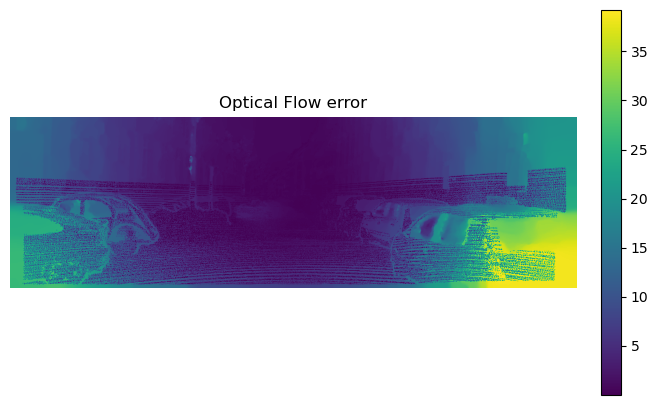

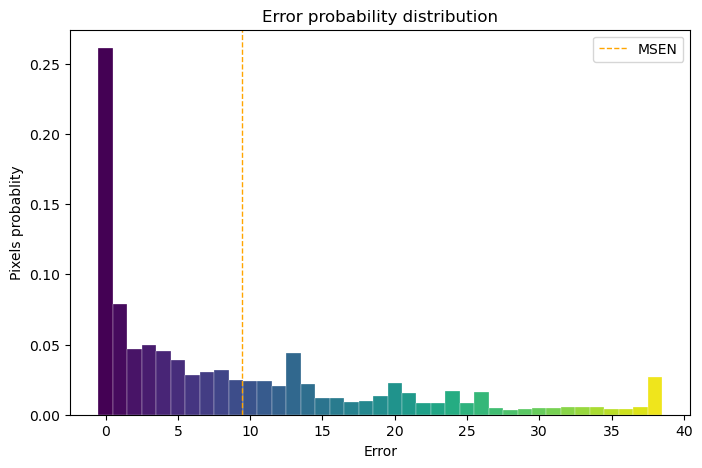

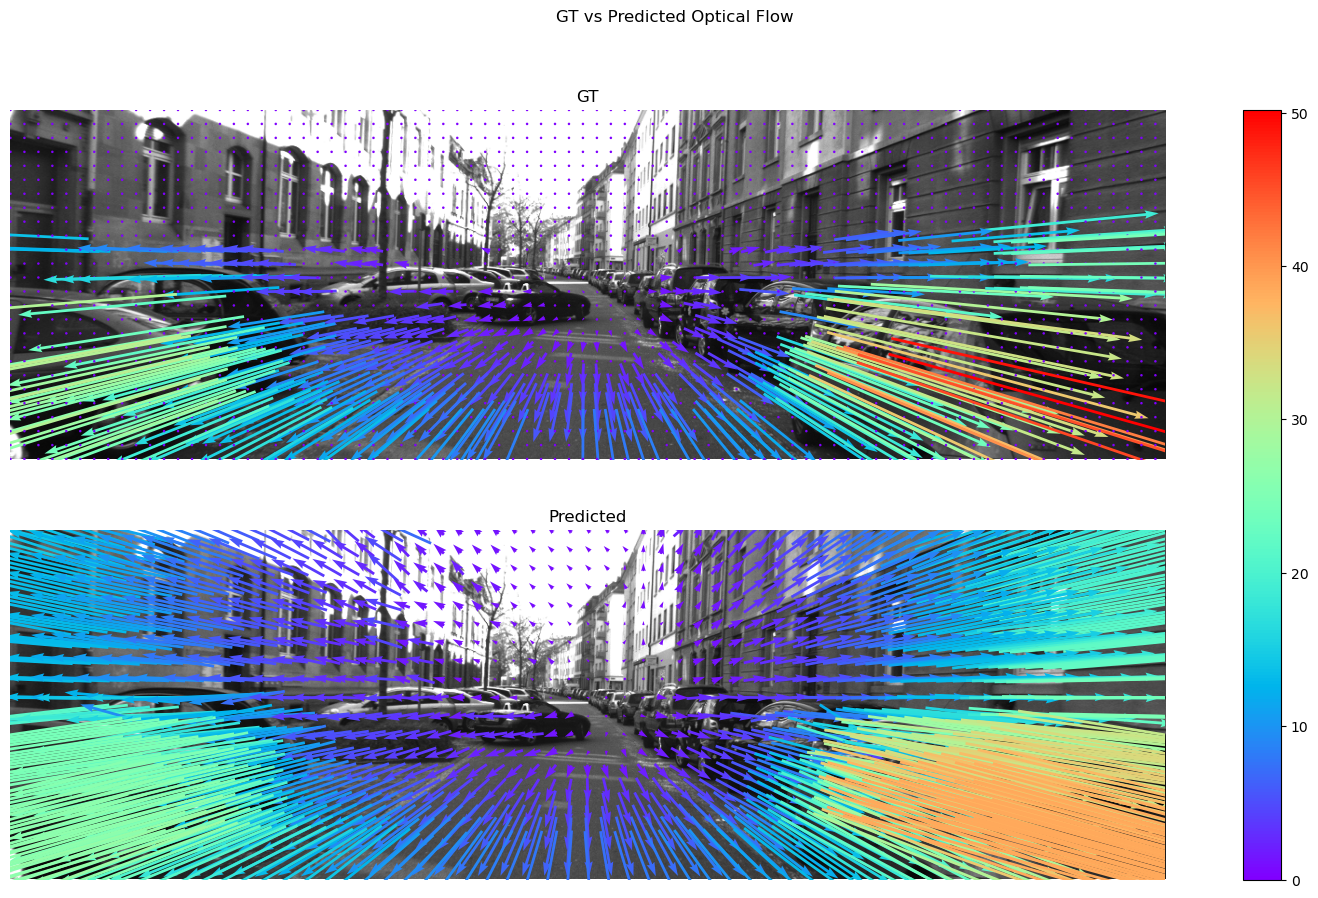

In [24]:
first = cv2.imread(r'kitti_data\training\image_0\000045_10.png').astype(float)  / 255
second = cv2.imread(r'kitti_data\training\image_0\000045_11.png').astype(float) / 255

alpha = 0.012
ratio = 0.75
minWidth = 20
nOuterFPIterations = 7
nInnerFPIterations = 1
nSORIterations = 30

u, v, im2W = pyflow.coarse2fine_flow(first, second, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations, nSORIterations)

pred_flow = np.dstack((u, v, np.ones_like(u)))

msen, pepn = compute_errors(gt_flow_img, pred_flow, 3, 'results_pyflow/', plots=True)
opticalFlow_arrows(first, gt_flow_img, pred_flow, 'results_pyflow/', 'pyflow')
HSVOpticalFlow2(pred_flow, 'results_pyflow/', 'pyflow_gt')
HSVOpticalFlow2(pred_flow, 'results_pyflow/', 'pyflow_pred')
print('MSEN:', msen)
print('PEPN:', pepn)

In [ ]:
first = cv2.imread(r'kitti_data\training\image_0\000045_10.png').astype(float)  / 255
second = cv2.imread(r'kitti_data\training\image_0\000045_11.png').astype(float) / 255

first.shape, second.shape, gt_flow.shape

u, v, im2W = pyflow.coarse2fine_flow(first, second)

pred_flow = np.stack((u, v, np.ones_like(u)), axis=2)

msen, sen = MSEN(gt_flow_img, pred_flow, './results')
pepn = PEPN(sen)

print('MSEN:', msen)
print('PEPN:', pepn)

In [ ]:
first = cv2.imread(r'kitti_data\training\image_0\000045_10.png')
second = cv2.imread(r'kitti_data\training\image_0\000045_11.png')
first_gray = cv2.cvtColor(first, cv2.COLOR_BGR2GRAY)
second_gray = cv2.cvtColor(second, cv2.COLOR_BGR2GRAY)
# Assuming prev_gray is your previous grayscale image
h, w = first_gray.shape

# Create a grid of points
y, x = np.mgrid[0:h, 0:w].astype(np.float32)
points = np.stack((x, y), axis=-1).reshape(-1, 1, 2)

# Now you can use cv2.calcOpticalFlowPyrLK() with all pixels
new_points, status, error = cv2.calcOpticalFlowPyrLK(first_gray, second_gray, points, None)

# Create a mask to select good points
new_points[status == 0] = 0
points[status == 0] = 0

flow = new_points - points

u = flow[:, 0, 0].reshape(h, w)
v = flow[:, 0, 1].reshape(h, w)

pred_flow = np.stack((u, v, np.ones_like(u)), axis=2)

msen, sen = MSEN(gt_flow_img, pred_flow, './results2')
pepn = PEPN(sen)

print('MSEN:', msen)
print('PEPN:', pepn)

In [ ]:
from core.raft import RAFT
from core.utils.utils import InputPadder
import torch

def load_image(img):
    img = np.array(img).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None]

import argparse

# Define a function to create and parse arguments
def create_args(small):
    parser = argparse.ArgumentParser()
    parser.add_argument('--small', action='store_true', help='use small model', default=small)
    parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
    args, unknown = parser.parse_known_args()  # This line parses the arguments
    return args

# Create an 'args' variable with default values or specified values.
args = create_args(small=False)

first = cv2.imread(r'kitti_data\training\image_0\000045_10.png')
second = cv2.imread(r'kitti_data\training\image_0\000045_11.png')

shape = first.shape

image1 = load_image(first)
image2 = load_image(second)

model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load('raft-kitti.pth', map_location=torch.device('cpu')))
model.eval()

padder = InputPadder(image1.shape)
image1, image2 = padder.pad(image1, image2)

with torch.no_grad():
    flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

# Resize flow_up to original image1 size
flow_up = torch.nn.functional.interpolate(flow_up, size=shape[:2], mode='bilinear', align_corners=True)
flow_up = flow_up.numpy().squeeze().transpose(1, 2, 0)

In [ ]:
pred_flow = np.stack((flow_up[:, :, 0], flow_up[:, :, 1], np.ones_like(flow_up[:, :, 0])), axis=2)
msen, sen = MSEN(gt_flow_img, pred_flow, './results2')
pepn = PEPN(sen)

print('MSEN:', msen)
print('PEPN:', pepn)